In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
%matplotlib inline
import os

In [16]:
train_df = pd.read_csv(os.path.join("../input/", "BBC News Train.csv"))
test_df = pd.read_csv(os.path.join("../input/", "BBC News Test.csv"))
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [17]:
targets_dict = {key : i for i,key in enumerate(train_df['Category'].unique()) }
reverse_targets = dict(zip(targets_dict.values(), targets_dict.keys()))
train_df['Category'] = train_df['Category'].apply(lambda x: targets_dict[x])
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,1
4,917,enron bosses in $168m payout eighteen former e...,0


# Data Exploration

In [18]:
train_df['Category'].value_counts()

3    346
0    336
2    274
4    273
1    261
Name: Category, dtype: int64

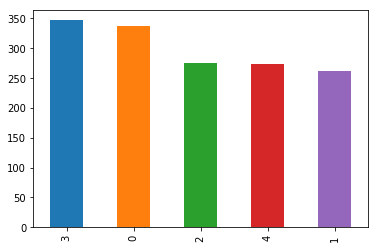

In [19]:
train_df['Category'].value_counts().plot.bar(ylim=0)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train_df.Text).toarray() 
labels = train_df.Category                        

In [21]:
features.shape 

(1490, 9927)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0),
]

In [23]:
CV = 5  
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] 

In [24]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').mean()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

,fold_idx,accuracy
model_name,,
LogisticRegression,2,0.973165
RandomForestClassifier,2,0.847763


In [25]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [26]:
# обучаем на всех данных
model.fit(features, labels)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Делаем предсказания

In [27]:
test_features = tfidf.transform(test_df.Text.tolist())
Y_pred = model.predict(test_features)

In [29]:
Y_pred_name =[]
for cat_id in Y_pred :
    Y_pred_name.append(reverse_targets[cat_id])

In [30]:
submission = pd.DataFrame({
        "ArticleId": test_df["ArticleId"],
        "Category": Y_pred_name
    })
submission.to_csv('submission.csv', index=False)
submission.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [32]:
#save models
from sklearn.externals import joblib
import pickle

model_path="logreg_model.pkl"
transformer_path="transformer.pkl"

pickle.dump(model,open(model_path, 'wb'))
pickle.dump(tfidf,open(transformer_path,'wb'))